## Lattice and Tensile Test examples

Text(0.5, 1.0, 'Lattice melt test')

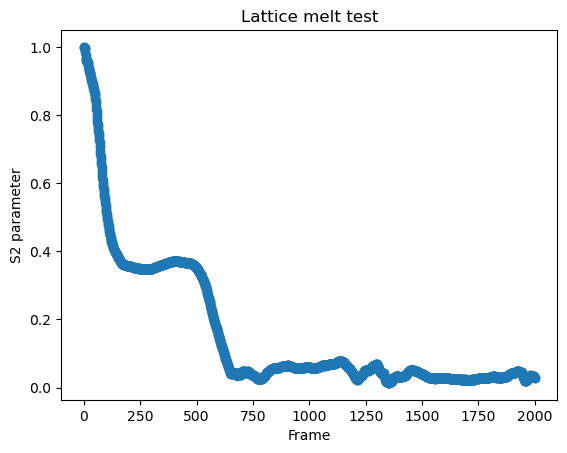

In [14]:
from nematic_order import nematic_order
import matplotlib.pyplot as plt
import numpy as np


lattice_orders,director = nematic_order("/home/jbieri/CME_lab/projects/SIC/preliminary-work/pps/coarse-graining/pps-melt-cg.gsd")
plt.scatter(range(len(lattice_orders)),lattice_orders)
plt.xlabel("Frame")
plt.ylabel("S2 parameter")
plt.title("Lattice melt test")

Text(0.5, 1.0, 'Tensile test')

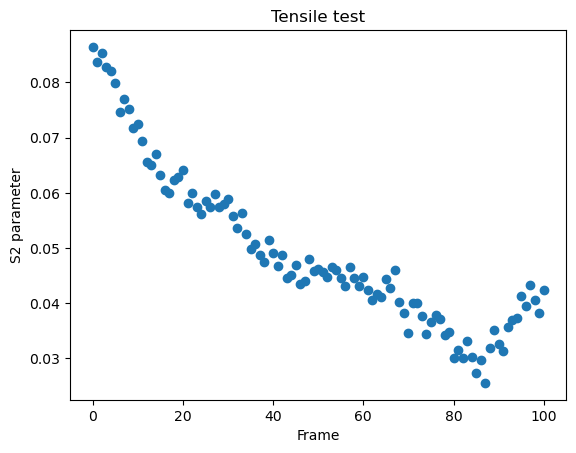

In [15]:
# Tensile test
tensile_orders,director = nematic_order("/home/jbieri/CME_lab/projects/SIC/preliminary-work/pps/coarse-graining/given-pps-cg.gsd")
plt.scatter(range(len(tensile_orders)),tensile_orders)
plt.xlabel("Frame")
plt.ylabel("S2 parameter")
plt.title("Tensile test")

## How to manipulate nematic order vectors

Nematic order is a measure of the average direction of molecules. It is a value between 0 and 1 with a value above 0.3 indicating some form of order within a system. A perfectly ordered system in which the orientations of all particles is alligned will have an order parameter of 1.0 as with the provided lattice melt test graph above.

## Bond vectors in opposite directions have the same nematic order

This short example simulation will be used to produce a GSD file with a resulting nematic order that should decrease as the simulation progresses. A graph showing the direction of the director vector of the first frame (as vizualised) will be produced. The nematic order of the initial frame is not 1 as the system is not fully coarse grained. Utilizing GRiTS to coarsegrain beyond removing hydrogens will cause the first frame to have an order of approximately 1.

In [16]:
from flowermd.library import PPS, OPLS_AA_PPS, BeadSpring
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
from flowermd.base import Molecule, Lattice, Simulation
from cmeutils.visualize import FresnelGSD
import gsd
import gsd.hoomd

molecule = PPS(num_mols=2, lengths=10) # Designating number of molecules and their length

box = Lattice(molecules=molecule, x = 2, y = 2, n = 1) # Box size and type
box.apply_forcefield(r_cut=2.5, force_field=OPLS_AA_PPS(), auto_scale=True,remove_charges=True, remove_hydrogens=True)

No charged group detected, skipping electrostatics.


In [17]:
box.hoomd_snapshot
hoomd_forces = box.hoomd_forcefield
hoomd_forces
lj_force = hoomd_forces[3]
cpu = hoomd.device.CPU()

In [18]:
sim = Simulation.from_system(system=box, gsd_write_freq=100, log_write_freq=100, device=cpu, gsd_file_name='small-pps-melt.gsd')

Initializing simulation state from a gsd.hoomd.Frame.


In [19]:
box.system.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Running a small melt simulation in order to produce a gsd file

In [20]:
sim.run_NVT(n_steps=1e4, kT=3.0, tau_kt=1.0)
sim.flush_writers()

Step 100 of 10000; TPS: 227.04; ETA: 0.7 minutes
Step 200 of 10000; TPS: 445.9; ETA: 0.4 minutes
Step 300 of 10000; TPS: 656.9; ETA: 0.2 minutes
Step 400 of 10000; TPS: 862.36; ETA: 0.2 minutes
Step 500 of 10000; TPS: 1057.76; ETA: 0.1 minutes
Step 600 of 10000; TPS: 1250.72; ETA: 0.1 minutes
Step 700 of 10000; TPS: 1439.22; ETA: 0.1 minutes
Step 800 of 10000; TPS: 1623.01; ETA: 0.1 minutes
Step 900 of 10000; TPS: 1801.93; ETA: 0.1 minutes
Step 1000 of 10000; TPS: 1967.76; ETA: 0.1 minutes
Step 1100 of 10000; TPS: 2130.77; ETA: 0.1 minutes
Step 1200 of 10000; TPS: 2291.21; ETA: 0.1 minutes
Step 1300 of 10000; TPS: 2442.89; ETA: 0.1 minutes
Step 1400 of 10000; TPS: 2594.07; ETA: 0.1 minutes
Step 1500 of 10000; TPS: 2746.2; ETA: 0.1 minutes
Step 1600 of 10000; TPS: 2889.0; ETA: 0.0 minutes
Step 1700 of 10000; TPS: 3031.95; ETA: 0.0 minutes
Step 1800 of 10000; TPS: 3169.33; ETA: 0.0 minutes
Step 1900 of 10000; TPS: 3292.56; ETA: 0.0 minutes
Step 2000 of 10000; TPS: 3422.65; ETA: 0.0 minut

Plotting the nematic order of the small melt example as the melt occurs

Text(0.5, 1.0, 'Nematic order parameter of small melt simulation by frame')

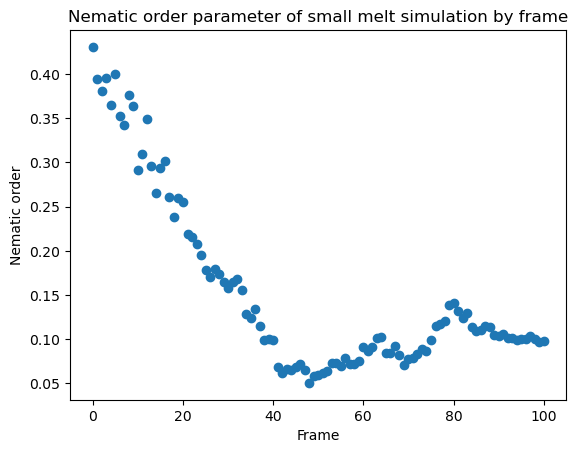

In [49]:
lattice_orders,director = nematic_order('small-pps-melt.gsd')
plt.scatter(range(len(lattice_orders)),lattice_orders)
plt.xlabel('Frame')
plt.ylabel('Nematic order')
plt.title('Nematic order parameter of small melt simulation by frame')

Plotting the nematic director of the small melt example

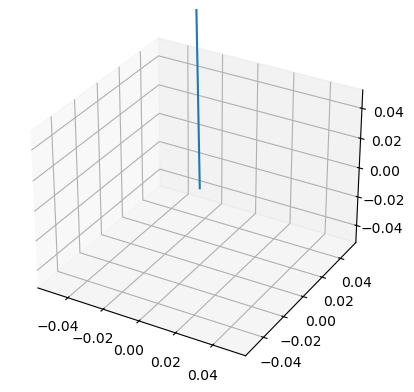

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
director = np.array(director)
ax.quiver(0,0,0,(director[:1,0]),(director[:1,1]),(director[:1,2]))